# The Very Basics of Musical Instruments Classification using Machine Learning
## Short-Time Fourier Transform (STFT) and an Introduction to Convolutional Neural Networks (CNN) using PyTorch

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="400px" alt="Business Card" align="left" >
</p>
<br>



Based on the Introduction to Deep Learning for Computer Vision using PyTorch by Kevin McGuinness, DCU
https://colab.research.google.com/drive/1gJAAN3UI9005ecVmxPun5ZLCGu4YBtLo

## Environments Configuration

In [2]:
## Check if inside Google Colab
inColab=False
## Check CPU or GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

try:
    import google.colab
    from google.colab import widgets
    from tensorboardcolab import TensorBoardColab
    print("Tensorflow Backend only for TensorBoard. Using PyTorch.")
    inColab=True
    
    # Create Directory for Checkpoints
    !mkdir -p checkpoints
    
    # Install torchaudio
    !apt-get update #Update
    !apt-get install sox libsox-dev libsox-fmt-all #Install Dependencies
    !pip3 install git+git://github.com/pytorch/audio #Install torchaudio
    
    # Clone Guitars.Ai Basics of Musical Instruments Classification Repository 
    !git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
    !unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
    path = "./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
    
    # Check for GPU
    if device.type == 'cuda':
        !nvidia-smi
        print(torch.cuda.get_device_name(0))        
    else:
        print("\nNo GPU Detected. Using CPU. Configure the Runtime for GPU.\n".upper())
        !cat /proc/cpuinfo
    
except Exception as e:
    if inColab:
        print("Error in Congiguration.%s" % e)
        stop
    
    print("Not inside Google Colab: %s. Using standard configurations." % (e))
    # Running in Different Environmet
    !cat /proc/cpuinfo
    path='./audio/london_phill_dataset_multi/'

cpu
Not inside Google Colab: No module named 'google.colab'. Using standard configurations.
cat: /proc/cpuinfo: No such file or directory


## Imports

In [4]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Visualization
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image
import IPython.display as ipd

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Deep Learning
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Random Seed
from numpy.random import seed
seed(0)
torch.manual_seed(0)

# Audio
import librosa.display, librosa
from librosa.util import normalize as normalize
import torchaudio
import torchaudio.transforms as transforms

# Configure Jupyter Cell Size
display(HTML("<style>.container { width:80% !important; }</style>"))

## Parameters

In [5]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # Length of the FFT 
hop_length = 512   # Number of samples in frames
duration = 1       # Duration of audio 1s

# Machine Learning Parameters
testset_size = 0.25   # Percentage of data for Testing
batch_size = 1        # How may samples per batch to load
num_epochs = 15       # Number of Epochs
lr = 0.01             # Learning Rate
    

## Get Audio Files and Generate Labels

In [6]:
# Get Audio Files and Generate Labels
files = []
labels =[]
classes=['flute','sax','oboe', 'cello','trumpet','viola']
for root, dirnames, filenames in os.walk(path):
    for i, filename in enumerate(fnmatch.filter(filenames, '*.mp3')):
        files.append(os.path.join(root, filename))
        print ("Get %s"%(filename))
        for name in classes:
            if fnmatch.fnmatchcase(filename, '*'+name+'*'):
                labels.append(name)
                break
        else:
            labels.append('other')
print("Found %d audio files in %s"%(len(files),path))

Get cello_Gs5_025_mezzo-piano_arco-normal.mp3
Get cello_A4_1_forte_arco-normal.mp3
Get cello_Gs4_025_fortissimo_arco-normal.mp3
Get cello_Gs5_025_forte_arco-normal.mp3
Get cello_A3_025_fortissimo_arco-normal.mp3
Get cello_Gs3_05_pianissimo_arco-normal.mp3
Get cello_A3_1_mezzo-piano_arco-normal.mp3
Get cello_Gs5_1_mezzo-piano_arco-normal.mp3
Get cello_Gs2_025_pianissimo_arco-normal.mp3
Get cello_Gs3_05_fortissimo_arco-normal.mp3
Get cello_Gs3_1_pianissimo_arco-normal.mp3
Get cello_A4_025_mezzo-piano_arco-normal.mp3
Get cello_Gs4_025_pianissimo_arco-normal.mp3
Get cello_A3_025_pianissimo_arco-normal.mp3
Get cello_Gs4_1_forte_arco-normal.mp3
Get cello_A4_1_pianissimo_arco-normal.mp3
Get cello_Gs5_15_pianissimo_arco-normal.mp3
Get cello_A2_15_piano_arco-normal.mp3
Get cello_Gs5_15_mezzo-piano_arco-normal.mp3
Get cello_A4_1_mezzo-piano_arco-normal.mp3
Get cello_A4_15_mezzo-piano_arco-normal.mp3
Get cello_A2_05_pianissimo_arco-normal.mp3
Get cello_A4_025_mezzo-forte_arco-col-legno-battuto.mp

## Encode Labels

In [7]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_int = labelencoder.transform(labels)
#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels=encoder.fit_transform(classes_int.reshape(len(classes_int),1))

6 classes: cello, flute, oboe, sax, trumpet, viola


## Create Train and Test Sets

In [8]:
# Create Train and Test Sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(files, classes_int)
files_arr=np.array(files)
labels_arr=np.array(onehot_labels)

for train_index, test_index in splits:
    train_set_files = files_arr[train_index]
    test_set_files = files_arr[test_index]
    train_labels = labels_arr[train_index]
    test_labels = labels_arr[test_index]

In [9]:
# Dataset Class
class Dataset(Dataset):
    'An abstract class representing a Dataset.'
    def __init__(self, files, labels):
        self.labels = labels
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        x, sr = librosa.load(self.files[index], sr=fs) # Load Audio File
        x, ind = librosa.effects.trim(x,top_db=60) #Trim
        x = normalize(x) # Normalize
        x = x.reshape(1,-1) # Reshape for TorchAudio PadTrim
        duration_in_samples = librosa.time_to_samples(duration, sr=fs) # Calculate the number os samples for a duration in Time
        X_torch = torch.from_numpy(x).to(device) 
        X_pad = transforms.PadTrim(max_len=int(duration_in_samples), channels_first=True)(X_torch) # Trim Array to defined duration
        window = torch.hann_window(n_fft).to(device) # Hann Window
        X_fft = torch.stft(X_pad, hop_length = hop_length, n_fft=n_fft, window=window) # PyTorch STFT
        x_fft = X_fft[:,:,:,1].squeeze().cpu().numpy() #Reshape for Librosa Amplitude_To_dB
        x_spec=librosa.amplitude_to_db(np.abs(x_fft), np.min) #Amplitude to dB
        scaler = StandardScaler() #Scikit Learn Standard Scaler
        x_spec = scaler.fit_transform(x_spec) #Apply Scaler
        x_spec = x_spec.reshape(1,x_spec.shape[0],x_spec.shape[1]) #Reshape for PyTorch
        X_torch = torch.from_numpy(x_spec) 
        y_labels = torch.tensor(self.labels[index]) #Labels Out
        return X_torch, y_labels

In [10]:
# Create Sets
train_set = Dataset(train_set_files, train_labels)
test_set = Dataset(test_set_files, test_labels)

In [11]:
# Data Loader.
training_generator = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0)
validation_generator = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [12]:
# Testing Dataset + Dataloader
# Get a random spectogram sample and plot 
dataiter = iter(DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0))
spectogram = dataiter.next()[0]
# Plot Sample Spectogram
plt.figure(figsize=(14,8));
plt.title("Short-Time Fourier Transform Spectogram\n")
librosa.display.specshow(spectogram[0].squeeze().numpy(),sr=fs,y_axis='log', x_axis='time', cmap="gray_r")
print("Spectogram Array Shape:",spectogram[0].squeeze().squeeze().numpy().shape)
plt.show();

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


AttributeError: module 'torchaudio.transforms' has no attribute 'PadTrim'

## Aux Function to Calculate Layer Shapes

Conv2d: $H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$
        $W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$

In [11]:
# Aux Function to Calculate Layer Shapes
# https://discuss.pytorch.org/t/utility-function-for-calculating-the-shape-of-a-conv-output/11173/5
def conv_shape(h_w, kernel_size=3, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w    

In [12]:
# Model Layers Shape Calculation
# Input Shape
input_shape=(87, 1025)
# Conv1 Input: 1 Channel, Output 16 Channels, Kernel: 3x3, Stride: 1x1, Dilatation=1x1, Padding=0
conv1_out_shape=conv_shape(input_shape)
print(conv1_out_shape)
pooling1_out_shape=conv_shape(conv1_out_shape, kernel_size=2, stride=2)
print(pooling1_out_shape)
# Conv1 Input: 16 Channel, Output 16 Channels, Kernel: 3x3, Stride: 1x1, Dilatation=1x1, Padding=0
conv2_out_shape=conv_shape(pooling1_out_shape)
print(conv2_out_shape)
pooling2_out_shape=conv_shape(conv2_out_shape, kernel_size=2, stride=2)
print(pooling2_out_shape)
# Flatten: 16 channles * Pooling2_H * Pooling2_W
print(16*pooling2_out_shape[0]*pooling2_out_shape[1])
# Fully Conected 81280 In and 16 Out
# Fully Connecte 16 In and 6 Out


(85, 1023)
(42, 511)
(40, 509)
(20, 254)
81280


## Define a CNN Model

In [13]:
# Model Architecture
class modelCNN(torch.nn.Module):
    def __init__(self):
        super(modelCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        self.pool1 = torch.nn.MaxPool2d(2)
        self.dropout1 = torch.nn.Dropout(p=0.4)
        self.conv2 = torch.nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        self.pool2 = torch.nn.MaxPool2d(2)
        self.dropout2 = torch.nn.Dropout(p=0.4)
        self.fc1 = torch.nn.Linear(16*254*20, 16)
        self.fc2 = torch.nn.Linear(16, 6)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(x.size()[0], -1)
        x = torch.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

In [14]:
# Weights Initialization Function
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [15]:
# Create Model and Initialize Weights
net = modelCNN()
net.apply(weights_init)
net.to(device)

modelCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4)
  (fc1): Linear(in_features=81280, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=6, bias=True)
)

In [16]:
# Display Number of Trainable Parameters
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of Trainable Parameters:",pytorch_total_params)

Number of Trainable Parameters: 1303078


## Aux Functions to Smooth Loss and Monitor Training Progress

In [17]:
# https://colab.research.google.com/drive/11v_mM2ImWdKDs_4qkoB9TdsQiPgVeeo2#scrollTo=NQgIwI5WC-07        
class ProgressMonitor(object):
    """
    Custom IPython progress bar
    """
    
    tmpl_train ="""
        <p> Train Epoch: {epoch} / {num_epochs} <br>
        Step: {value} / {length} - Train Loss: {loss:0.4f} / Accuracy: {accuracy:0.4f}   </p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
        <br>"""
    
    tmpl_test= """
        <p>Test Epoch: {epoch} / {num_epochs} <br>
        Step: {value} / {length} - Test Loss: {loss:0.4f}  /  Accuracy: {accuracy:0.4f} </p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
        <br>"""

    def __init__(self, length, mode):
        self.length = length
        self.count = 0
        self.mode = mode
        self.display = display(self.html(0, 0, 0, 0, 0, mode), display_id=True)   
        
    def html(self, count, epoch, num_epochs, loss, accuracy, mode="train"):
        if mode=="train":
            return HTML(self.tmpl_train.format(length=self.length, value=count, epoch=epoch, num_epochs=num_epochs, loss=loss, accuracy=accuracy))
        else:
            return HTML(self.tmpl_test.format(length=self.length, value=count, epoch=epoch, num_epochs=num_epochs, loss=loss, accuracy=accuracy))
        
    def update(self, count, epoch, num_epochs, loss, accuracy, mode="train"):
        self.count += count
        self.display.update(self.html(self.count, epoch, num_epochs, loss, accuracy, mode))

# https://colab.research.google.com/drive/1gJAAN3UI9005ecVmxPun5ZLCGu4YBtLo#scrollTo=ZvoPaJvs7Eem
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

## Define Loss Function and Optimizer

In [18]:
class categorical_cross_entropy(nn.Module):
    ''' Categorical Cross Entropy similar to Keras/TensorFlow
        "Categorical crossentropy between an output tensor and a target tensor" - https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
        https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/keras/backend.py
        target: A tensor of the same shape as `inputX`.
        inputX: A tensor resulting from a softmax
    '''
    def __init__(self):
        super(categorical_cross_entropy, self).__init__()

    def forward(self, inputX, target):
        eps=1e-10
        tmp = inputX.clone()
        tmp /= torch.sum(tmp)
        torch.clamp_(tmp, min=eps, max = 1-eps)
        return torch.mean(-torch.sum(target * torch.log(tmp.double()), dim=-1), dim=-1)

In [19]:
# Loss Function
criterion = categorical_cross_entropy()

# Optimizer
optimizer = optim.SGD(net.parameters(), lr=lr)

## Aux Functions to Save and Load Checkpoints

In [20]:
def save_checkpoint(optimizer, criterion, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch,
        'criterion': criterion.state_dict()
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, criterion, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    criterion.load_state_dict(checkpoint_dict['criterion'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

# Define a Train Function

In [21]:
def train(model, epoch, num_epochs, monitoring=True):
    
    if monitoring:
         #Create a Progress Bar 
        if inColab:
            try:
                # create a progress bar
                with grid.output_to(0,0):
                    progress = ProgressMonitor(length=len(train_set), mode="train")
            except:
                pass
        else:
            progress = ProgressMonitor(length=len(train_set), mode="train")
        
    
    # Initialize Metrics
    train_loss = MovingAverage()
    train_acc = MovingAverage()
    
    # Train Stage
    model.train()
    
    # keep track of X predictions amd metrics
    x_pred = []

    for i, (batch, targets) in enumerate(training_generator):
        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions = model(batch)

        # calculate the loss
        loss = criterion(predictions, targets)
        #loss = cross_entropy(predictions, targets)

        # backpropagate to compute gradients
        loss.backward()

        # update model weights
        optimizer.step()

        # update average loss
        train_loss.update(loss)
            
        # save X predictions
        x_pred.extend(predictions.argmax(dim=-1).cpu().numpy())
        
        # calculate accuracy
        x_pred_torch = torch.tensor(x_pred, dtype=torch.int64)
        accuracy = torch.mean((x_pred_torch == torch.tensor(np.argmax(train_set.labels[:len(x_pred)],axis=1), dtype=torch.int64)).float())
        
        # update average accuracy
        train_acc.update(accuracy)
            
        # Update Progress Bar
        if monitoring:
                progress.update(batch.shape[0], epoch, num_epochs, train_loss, train_acc, mode="train")
                
    #TensorBoard
    if inColab:
        try:
            tbc.save_value('Loss', 'train_loss', epoch, train_loss.value)
            tbc.save_value('Accuracy', 'train_acc', epoch, train_acc.value)
        except:
            pass

    # Save a checkpoint
    checkpoint_filename = 'checkpoints/basicInstrumetClassif-{:03d}.pkl'.format(epoch)
    save_checkpoint(optimizer, criterion, model, epoch, checkpoint_filename)
    return train_loss.value, train_acc.value , x_pred

## Define a Test Function

In [22]:
def test(model, epoch, num_epochs, monitoring=True):
    
    if monitoring:
        #Create a Progress Bar
        if inColab:
            try:
                with grid.output_to(0,0):
                    progress = ProgressMonitor(length=len(test_set), mode="test")
            except:
                pass
        else:
            progress = ProgressMonitor(length=len(test_set), mode="test")
    
    
    # validation phase
    model.eval()
    
    #Initialize Metrics
    valid_loss = RunningAverage()
    valid_acc = RunningAverage()

    # keep track of predictions
    y_pred = []
    
    with torch.no_grad():
        for batch, targets in validation_generator:

            # Move the training batch to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # update running loss value
            valid_loss.update(loss)

            # save predictions
            y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

            # Validation Accuracy
            y_pred_torch = torch.tensor(y_pred, dtype=torch.int64)
            accuracy = torch.mean((y_pred_torch == torch.tensor(np.argmax(test_set.labels[:len(y_pred)],axis=1), dtype=torch.int64)).float())
            valid_acc.update(accuracy)

            # Update Progress Bar
            if monitoring:
                    progress.update(batch.shape[0], epoch, num_epochs, valid_loss, valid_acc, mode="test")
                    
    #TensorBoard
    if inColab:
        try:
            tbc.save_value('Loss', 'valid_loss', epoch, valid_loss.value)
            tbc.save_value('Accuracy', 'valid_acc', epoch, valid_acc.value)
        except:
            pass
        
    return valid_loss.value, valid_acc.value, y_pred
    

## Define an Experiment Function

In [23]:
def experiment(model, num_epochs = num_epochs, first_epoch = 1, monitoring=True):
    
    #Initialze Metrics
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    if inColab:
        global tbc
        tbc = TensorBoardColab()
        if monitoring:
            # create a 1x1 grid to display the loss and progress
            global grid
            grid = widgets.Grid(3,1)
    
    for epoch in range(first_epoch, first_epoch + num_epochs):
        #Train Model
        train_loss,train_acc,train_predictions=train(model, epoch, num_epochs, monitoring)
        #Save Test Losses and Accuracies
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        #Test Model
        valid_loss,valid_acc, valid_predictions = test(model, epoch, num_epochs, monitoring)
        #Save Test Losses and Accuracies
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        
        if monitoring:
            if inColab:
                try:
                    # Plot loss
                    with grid.output_to(1, 0):
                        grid.clear_cell()
                        plt.figure(figsize=(10,6))
                        epochs = range(first_epoch, epoch + 1)
                        plt.plot(epochs, train_losses, '-o', label='Training')
                        plt.plot(epochs, valid_losses, '-o', label='Validation')
                        plt.legend()
                        plt.title('Learning curves')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.xticks(epochs)
                        plt.show()

                    # Plot Accuracy
                    with grid.output_to(2, 0):
                        grid.clear_cell()
                        plt.figure(figsize=(10,6))
                        epochs = range(first_epoch, epoch + 1)
                        plt.plot(epochs, train_accuracies, '-o', label='Training')
                        plt.plot(epochs, valid_accuracies, '-o', label='Validation')
                        plt.legend()
                        plt.title('Learning curves')
                        plt.xlabel('Epoch')
                        plt.ylabel('Accuracy')
                        plt.xticks(epochs)
                        plt.show()
                except:
                    pass
                
    return {"train_loss": train_losses, "train_acc": train_accuracies, "valid_loss" : valid_losses, 
            "valid_acc" : valid_accuracies, "predictions" :valid_predictions }

## Run Experiment

In [24]:
# Run Experiment
hist = experiment(net, num_epochs=num_epochs, monitoring=True)

## Evaluate Model

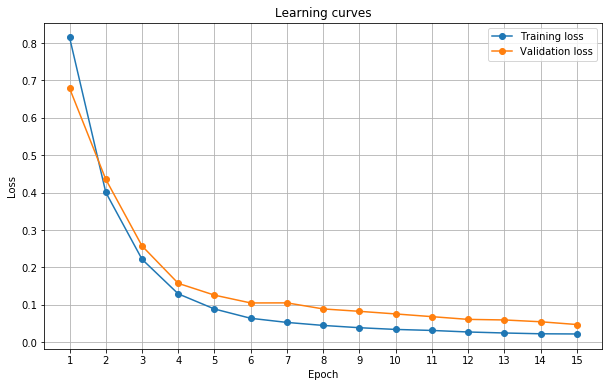

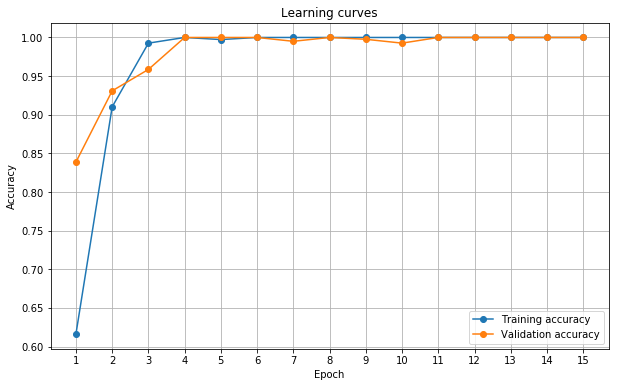

In [25]:
epochs = range(1, len(hist["train_loss"]) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, hist["train_loss"], '-o', label='Training loss')
plt.plot(epochs, hist["valid_loss"], '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, hist["train_acc"], '-o', label='Training accuracy')
plt.plot(epochs, hist["valid_acc"], '-o', label='Validation accuracy')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid()
plt.show()

In [26]:
# Number of Validation Errors
num_errors = torch.sum((torch.tensor(hist["predictions"]) != torch.tensor(np.argmax(test_set.labels,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))

Validation errors 0 (out of 150)


In [27]:
# Mistakes
error_indicator = torch.tensor(hist["predictions"]) != torch.tensor(np.argmax(test_set.labels,axis=1))
print("Wrongly predicted Audio Files", test_set.files[np.where(error_indicator)])
print("Correct Classes:", np.array(labels)[test_index[np.where(error_indicator)]])
print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["predictions"])[np.where(error_indicator)])))

Wrongly predicted Audio Files []
Correct Classes: []
Predicted as: []


In [28]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["predictions"]));

In [29]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int[test_index], hist["predictions"],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int[test_index], hist["predictions"],average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int[test_index], hist["predictions"], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int[test_index], hist["predictions"] ,normalize=True), accuracy_score(classes_int[test_index], hist["predictions"],normalize=False) )
print("Number of samples:",classes_int[test_index].shape[0])

print(classification_report(classes_int[test_index], hist["predictions"]))

Recall:  [1. 1. 1. 1. 1. 1.]
Precision:  [1. 1. 1. 1. 1. 1.]
F1-Score:  [1. 1. 1. 1. 1. 1.]
Accuracy: 1.00  , 150
Number of samples: 150
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        25

   micro avg       1.00      1.00      1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int[test_index], hist["predictions"])
np.set_printoptions(precision=2)

In [31]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

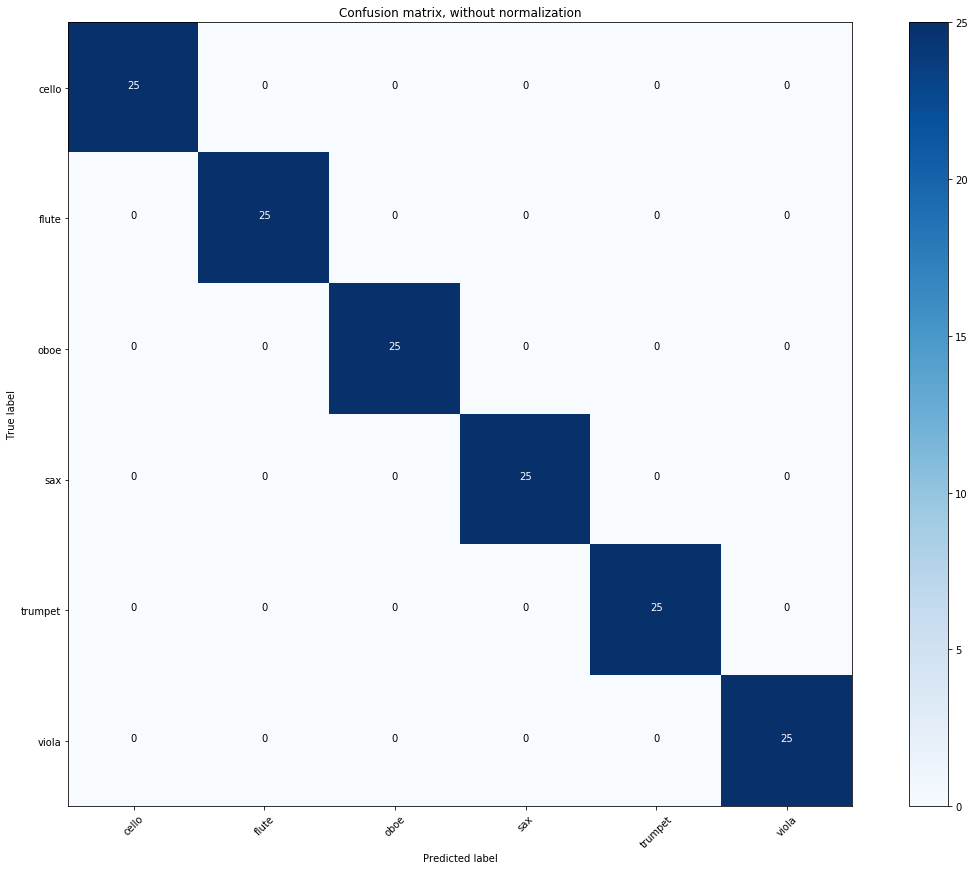

In [32]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [33]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(classes_int[test_index], hist["predictions"])) if e1 != e2]

In [34]:
# Find wrong predicted audio files
print("Correct Classes:", np.array(labels)[test_index[wrong_predictions]])
print("Predicted as:", predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

Correct Classes: []
Predicted as: []
[]


## Resume Training

In [35]:
!ls checkpoints

basicInstrumetClassif-001.pkl  basicInstrumetClassif-009.pkl
basicInstrumetClassif-002.pkl  basicInstrumetClassif-010.pkl
basicInstrumetClassif-003.pkl  basicInstrumetClassif-011.pkl
basicInstrumetClassif-004.pkl  basicInstrumetClassif-012.pkl
basicInstrumetClassif-005.pkl  basicInstrumetClassif-013.pkl
basicInstrumetClassif-006.pkl  basicInstrumetClassif-014.pkl
basicInstrumetClassif-007.pkl  basicInstrumetClassif-015.pkl
basicInstrumetClassif-008.pkl


In [36]:
epoch = load_checkpoint(optimizer, criterion, net, 'checkpoints/basicInstrumetClassif-002.pkl')
print('Resuming training from epoch', epoch)
hist = experiment(net, num_epochs=2, first_epoch=epoch)

Resuming training from epoch 2
